## Preparing to get the velocity of the gas surrounding the galaxy

I was hoping that the catalogue might be able to give gas velocities, but it looks like I'll actually need to go into the particle data itself.  That requires simulation work, which is done in a separate script, gasvelocities_readeagle.py.  

This code explores the emission maps, to select galaxies surrounded by H-alpha emission and uses the galaxy catalogue to print off their locations, for investigation with the following script.

In [1]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u

from matplotlib.patches import ConnectionPatch

import os
import get_halpha_SB

%matplotlib inline

%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'
%run 'mask_galaxies.ipynb'

In [55]:
def plotcutout(data,minx,miny,size):
    shape = data.shape[0]
    data_cutout = data[int(minx/100.*shape):int((minx+size)/100.*shape),int(miny/100.*shape):int((miny+size)/100.*shape)]
    return data_cutout

def plotbox(minx,miny,sizex,sizey,ax,colour='black',linewidth=1,linestyle='-'):
    ax.plot([minx,minx+sizex,minx+sizex,minx,minx],[miny,miny,miny+sizey,miny+sizey,miny],\
            linestyle=linestyle,color=colour,linewidth=linewidth)

def plotdata(data,ax=None,bounds=None,colorbar=False,label=None,colmap = 'viridis'):
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
    #ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    if bounds is None:
        xlen= data.shape[0]; ylen = data.shape[1]
        img = ax.imshow(data,origin='lower',interpolation='nearest',extent=(0,xlen,0,ylen),cmap=cm.get_cmap(colmap))
    else:
        img = ax.imshow(data,origin='lower',vmin=bounds[0],vmax=bounds[1],interpolation='nearest')#,cmap=cm.get_cmap(colmap))
    ax.set_aspect('equal')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()
    if label is not None:
        ax.text(0.0,0.9,label,transform=ax.transAxes,color='white')

def makemap(data,size,ax,Vmin = None,Vmax = None,colmap='viridis',xystarts = [0.,0.],title = '',colorbar=True,mockobs=False,labelaxes=True,label=''):
    fontsize=13
    #xystarts = [0.,0.] # lower left origin of the plot
    
    if mockobs:
        clabel = r'log signal (photons)'
    else:
        clabel = r'log photons/cm$^2$/s/sr'
    
    if type(size) == float or type(size) == int:
        print('The type of size is '+str(type(size)))
        xsize = size
        ysize = size
    else:
        print('The type of size is '+str(type(size)))
        xsize = size[0]
        ysize = size[1]
    
    #fig = plt.figure(figsize = (5.5, 5.)) # large size just as a trick to get higher resolution
    #fig = plt.figure(figsize = (11., 10.))
    
    if labelaxes:
        ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
        ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
        ax.tick_params(labelsize=fontsize) #,top=True,labeltop=True)
        ax.xaxis.set_label_position('bottom') 
    else:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    
    colmap = 'viridis' #'afmhot'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    
    # nearest neighbour interpolation does not do any averaging, it just picks the nearest point and uses that as the value for a specific section in the image
    img = ax.imshow(data.T,extent=(xystarts[0],xystarts[0]+xsize,xystarts[1],xystarts[1]+ysize),origin='lower', \
                    cmap=cm.get_cmap(colmap),interpolation='nearest', vmin = Vmin, vmax=Vmax)
    
    #plt.title(label,fontsize=fontsize)
    div = axgrid.make_axes_locatable(ax)
        
    if colorbar:
        cax = div.append_axes("top",size="5%",pad=0.1)
        cbar = plt.colorbar(img, cax=cax,orientation='horizontal')

        cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
        cbar.ax.xaxis.set_label_position('top')      
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.solids.set_edgecolor("face")
        #cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)
    
    font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'bold',
        'size': 12,
        }
    
    font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }


def plotgalboxes(xgal,ygal,rhgas,rhstar,mgal,ax1,boxsize=0.4,linestyle='-'):
    for i in range(len(xgal)):
        if mgal[i]>10**9:
            minx,miny,sizex,sizey = xgal[i]-boxsize/2.,ygal[i]-boxsize/2.,boxsize,boxsize
            plotbox(minx,miny,sizex,sizey,ax1,colour='grey',linestyle=linestyle)

def pltimg(data_FOV,ax,xystarts,size,label=None,colmap = 'viridis',colorbar=True,labelaxes=True,ylabelside='left',Vmin=-4.5,Vmax=8):
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    img = ax.imshow(data_FOV.T,extent=(xystarts[0],xystarts[0]+size[0],xystarts[1],xystarts[1]+size[1]),\
                    origin='lower', cmap=cm.get_cmap(colmap),interpolation='nearest',vmin=Vmin,vmax=Vmax)
    if labelaxes:
        fontsize=13
        ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
        ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
        ax.locator_params(axis='y', nticks=3)
        ax.tick_params(labelsize=fontsize) #,top=True,labeltop=True)
        ax.xaxis.set_label_position('top') 
        ax.xaxis.tick_top()
        if ylabelside=='right':
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
    else:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("top",size="5%",pad=0.1)
        cbar = plt.colorbar(img, cax=cax,orientation='horizontal')
    if label is not None:
        ax.text(0.0,0.9,label,transform=ax.transAxes,color='white',fontsize=9)

def putinbounds(xy):
    x,y = xy
    if x>xystarts1_50[0]+size1_50[0]:
        print 'setting x (%s) to %s since too large'%(x,xystarts1_50[0]+size1_50[0])
        x = xystarts1_50[0]+size1_50[0]
    if x<xystarts1_50[0]:
        print 'setting x (%s) to %s since too small'%(x,xystarts1_50[0])
        x = xystarts1_50[0]
    if y>xystarts1_50[1]+size1_50[1]:
        print 'setting y (%s) to %s since too large'%(y,xystarts1_50[1]+size1_50[1])
        y = xystarts1_50[1]+size1_50[1]
    if y<xystarts1_50[1]:
        print 'setting y (%s) to %s since too small'%(y,xystarts1_50[1]+size1_50[1])
        y = xystarts1_50[1]
    return (x,y)

def searchgals(xmin,xmax,ymin,ymax,zmin,zmax,verbose,debug,mySim = 'RefL0100N1504'):
    
    con   = sql.connect("dlokhorst",password="mxdPB54Y")  

    myQuery  = "SELECT \
                SH.GalaxyID, \
                SH.StarFormationRate as SFR, \
                SH.CentreOfPotential_x, \
                SH.CentreOfPotential_y, \
                SH.CentreOfPotential_z, \
                SH.SubGroupNumber, \
                SH.GroupNumber, \
                SH.Velocity_x, \
                SH.Velocity_y, \
                SH.Velocity_z, \
                SH.MassType_Star, \
                SH.HalfMassProjRad_Gas, \
                SH.HalfMassProjRad_Star \
            FROM \
                %s_SubHalo as SH \
            WHERE \
                SH.SnapNum = 28 and \
                SH.CentreOfPotential_x >= %s and \
                SH.CentreOfPotential_x <= %s and \
                SH.CentreOfPotential_y >= %s and \
                SH.CentreOfPotential_y <= %s and \
                SH.CentreOfPotential_z >= %s and \
                SH.CentreOfPotential_z <= %s"%(mySim,xmin,xmax,ymin,ymax,zmin,zmax)
 

                #  and \
              #  SH.StarFormationRate > 0.00001 

    if verbose:
        print myQuery
    
    myData = sql.execute_query(con,myQuery)

    xgal = myData['CentreOfPotential_x'][:]   # cMpc
    ygal = myData['CentreOfPotential_y'][:]   # cMpc
    zgal = myData['CentreOfPotential_z'][:]      # cMpc
    mgal = myData['MassType_Star'][:]         # M_solar
    rhgas = myData['HalfMassProjRad_Gas'][:]  # pkpc
    rhstar= myData['HalfMassProjRad_Star'][:] # pkpc
    gn   = myData['GroupNumber'][:] # pkpc
    sgn  = myData['SubGroupNumber'][:] # pkpc
    vxgal  = myData['Velocity_x'][:] # pkpc
    vygal  = myData['Velocity_y'][:] # pkpc
    vzgal  = myData['Velocity_z'][:] # pkpc

    if debug:
        plt.hist(zgal,label='zgal')
        plt.hist(xgal,label='xgal')
        plt.hist(ygal,label='ygal')
        plt.legend()
    
    return xgal,ygal,zgal,mgal,rhgas,rhstar,gn,sgn,vxgal,vygal,vzgal


Eventually, we want to use the 100Mpc box data, in which case, we can load and look for the galaxies with the following code.  For now, with only the 12.5Mpc box particle data, we will prepare the code with just that.  
### SKIP down to the bottom to where we do the 12.5Mpc box size stuff

In [11]:
machine='coho'


In [2]:
### STUFF WE MUST HAVE:
slicewidth = 20.        # initial value
resolution = None      # initial value   # arcsec/pixel
distance   = '100Mpc'  # initial value
data_FOV =None  # from extract_FOV
xystarts =None  # from extract_FOV
size     =None  # from extract_FOV

data_tuple = loaddata(machine=machine, distance=distance, slicewidth=slicewidth)  ### I want this to set the resolution too

### For the full size plots, use low resolution data:
data_tuple_100 = loaddata(machine=machine, distance=distance, slicewidth=slicewidth, resolution=100.)  ### I want this to set the resolution too
#data_tuple = data_tuple_100


In [5]:
data = data_tuple[0]
resolution = data_tuple[3]
print data.shape
print resolution

In [6]:
FOV1_50, xystarts1_50, size1_50    = extractFOV(data_tuple,  resolution, '50Mpc', x_center = 50.5, y_center = 13.5)

In [24]:
### grab out the galaxies inside this FOV
xmin,xmax,ymin,ymax,zmin,zmax = xystarts1_50[0],xystarts1_50[0]+size1_50[0],xystarts1_50[1],xystarts1_50[1]+size1_50[1],10.,15.
xgal_50,ygal_50,zgal_50,mgal_50,rhgas_50,rhstar_50 = searchgals(xmin,xmax,ymin,ymax,zmin,zmax,False,False)

## grab the more massive galaxies
Mpcperpix = 0.477/1000.*(1.+0.0235) * resolution         # at 100 Mpc from us
condition_9andup = np.array( (mgal_50 > 10**9) & (rhstar_50*5. > (Mpcperpix*1000.)) & (rhgas_50*5. > (Mpcperpix*1000.)) )
ii_9andup = np.array(np.where(condition_9andup)[0]) 
xgal_9andup     = np.array(xgal_50[ii_9andup])
ygal_9andup     = np.array(ygal_50[ii_9andup])
mgal_9andup     = np.array(mgal_50[ii_9andup])
rhstar_9andup   = np.array(rhstar_50[ii_9andup])
rhgas_9andup    = np.array(rhgas_50[ii_9andup])
print len(xgal_9andup)
# sort by position
sortedindices = np.argsort(xgal_9andup) # np.flipud(...)
xgal_9andup     = xgal_9andup[sortedindices]
ygal_9andup     = ygal_9andup[sortedindices]
mgal_9andup     = mgal_9andup[sortedindices]
rhstar_9andup   = rhstar_9andup[sortedindices]
rhgas_9andup    = rhgas_9andup[sortedindices]

6


In [25]:
len(xgal_50)

541

In [10]:
data = data_tuple[0]; xsize = data.shape[0]; ysize = data.shape[1]
print data.shape

(32000, 32000)


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


50.2369918823 13.3346481323 50.7369918823 13.8346481323


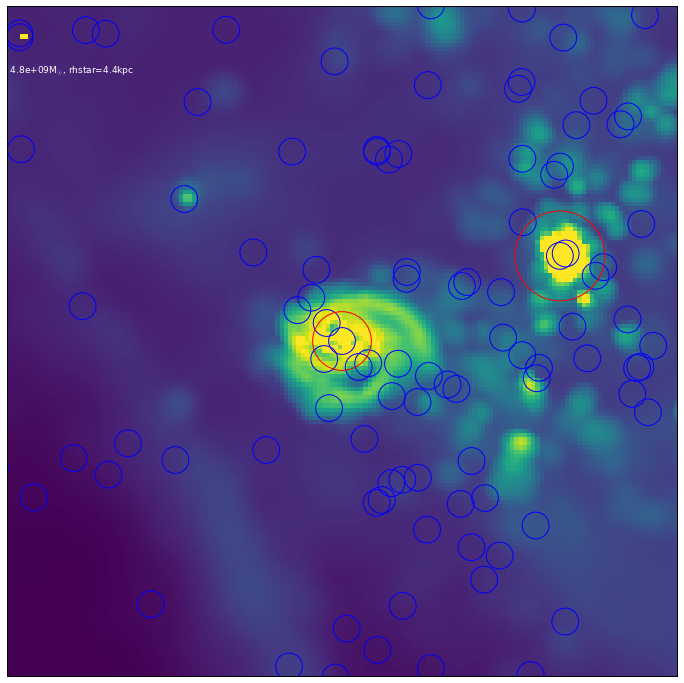

In [32]:
fig, ax1 = plt.subplots(1,1,figsize=[12, 12])

Vmin=-2;Vmax=4

#### plot main map
#makemap(FOV1_50,size1_50,ax1,xystarts = xystarts1_50,Vmin=Vmin,Vmax=Vmax)

j=2
boxsize = 0.5
minx,miny,maxx,maxy = xgal_9andup[j]-boxsize/2.,ygal_9andup[j]-boxsize/2.,xgal_9andup[j]+boxsize/2.,ygal_9andup[j]+boxsize/2.
xystarts_tiny=[minx,miny]; size_tiny=[boxsize,boxsize] 
data_tiny=data[minx*xsize/100.:maxx*xsize/100.,miny*ysize/100.:maxy*ysize/100.]

pltimg(data_tiny,ax1,xystarts_tiny,size_tiny,colorbar=False,labelaxes=False,Vmin=Vmin,Vmax=Vmax,\
        label=r' %.1eM$_{\odot}$, rhstar=%.1fkpc'%((mgal_9andup[j]),rhstar_9andup[j]))

print minx,miny,maxx,maxy

for i in range(len(xgal_50)):
    circle1 = plt.Circle((xgal_50[i],ygal_50[i]),radius=0.01, color='blue',fill=False)
    ax1.add_artist(circle1)
    
for j in range(len(xgal_9andup)):
    circle1 = plt.Circle((xgal_9andup[j],ygal_9andup[j]), \
                         radius=rhstar_9andup[j]/1000.*5., color='red',fill=False)
    ax1.add_artist(circle1)

### Start here for the 12 Mpc stuff!

In [12]:
machine = 'coho'

In [33]:
if machine == 'coho':
    data = np.load('/Users/deblokhorst/Documents/EAGLE/12Mpc/emission_halpha_L0012_total_noSFR.npz')['arr_0']
else:
    print "Where is the 12Mpc data??"

In [56]:
# Find the galaxies
xmin=0;xmax=12.5;ymin=0;ymax=12.5;zmin=0;zmax=12.5
xgal,ygal,zgal,mgal,rhgas,rhstar,gn,sgn,vxgal,vygal,vzgal = searchgals(xmin,xmax,ymin,ymax,zmin,zmax,False,False,mySim ='RefL0012N0188')

In [57]:
# Grab out the more massive galaxies
#Mpcperpix = 0.477/1000.*(1.+0.0235) * resolution         # at 100 Mpc from us
condition_9andup = np.array( (mgal > 10**9) ) ## & (rhstar_50*5. > (Mpcperpix*1000.)) & (rhgas_50*5. > (Mpcperpix*1000.)) )
ii_9andup = np.array(np.where(condition_9andup)[0]) 
xgal_9andup     = np.array(xgal[ii_9andup])
ygal_9andup     = np.array(ygal[ii_9andup])
zgal_9andup     = np.array(zgal[ii_9andup])
mgal_9andup     = np.array(mgal[ii_9andup])
gn_9andup       = np.array(gn[ii_9andup])
sgn_9andup      = np.array(sgn[ii_9andup])
vxgal_9andup    = np.array(vxgal[ii_9andup])
vygal_9andup    = np.array(vygal[ii_9andup])
vzgal_9andup    = np.array(vzgal[ii_9andup])
### add velocities

len(sgn_9andup)

23

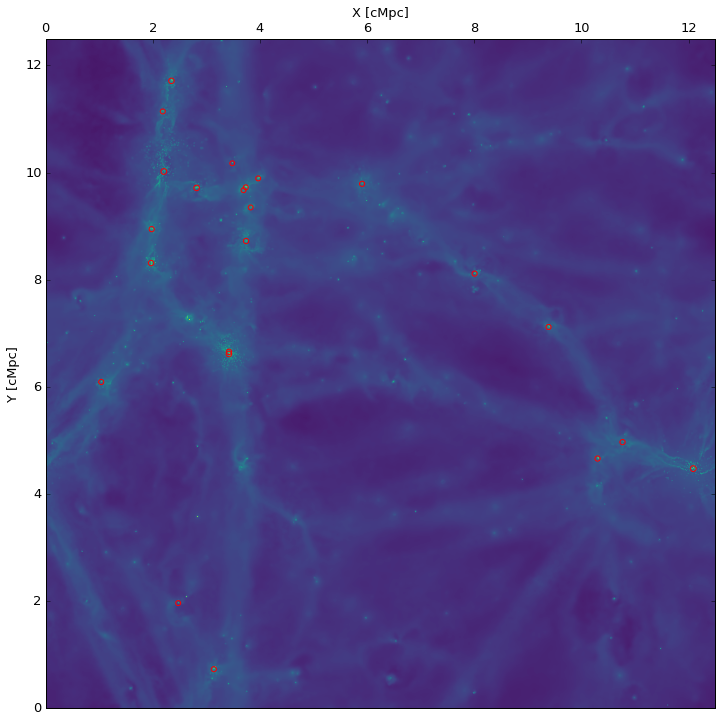

In [22]:
fig, ax1 = plt.subplots(1,1,figsize=[12, 12])
# Plot the emission map
pltimg(data,ax1,[0,0],[12.5,12.5],colorbar=False,labelaxes=True)

# Plot the locations of the galaxies from the catalogue    
for j in range(len(xgal_9andup)):
    circle1 = plt.Circle((xgal_9andup[j],ygal_9andup[j]), \
                         radius=np.log10(mgal_9andup[j])/1000.*5., color='red',fill=False)
    ax1.add_artist(circle1)

4000
GN: 1, SGN: 0, x: 12.0881, y: 4.47437, z: 1.41333, vx: 25.2508, vy: 25.5319, vz: 2.74462
GN: 2, SGN: 0, x: 2.20661, y: 10.021, z: 12.4539, vx: 26.0379, vy: -33.5737, vz: -0.577262
GN: 3, SGN: 0, x: 3.42004, y: 6.61359, z: 7.57863, vx: -30.3179, vy: 35.9411, vz: 17.4218
GN: 3, SGN: 1, x: 3.42185, y: 6.65443, z: 7.57871, vx: -56.3813, vy: 269.092, vz: -187.827
GN: 4, SGN: 0, x: 2.81691, y: 9.71423, z: 1.67911, vx: -33.7948, vy: -19.8147, vz: -62.8288
GN: 5, SGN: 0, x: 1.96703, y: 8.31241, z: 11.1665, vx: 28.3246, vy: 18.1367, vz: 82.2149
GN: 6, SGN: 0, x: 2.34734, y: 11.7135, z: 11.7001, vx: -29.8486, vy: -99.9179, vz: 42.1667
GN: 7, SGN: 0, x: 3.74037, y: 8.72288, z: 6.17176, vx: -0.72455, vy: -25.9278, vz: -4.65538
GN: 8, SGN: 0, x: 5.90654, y: 9.79022, z: 1.73553, vx: -51.776, vy: -19.2828, vz: 14.9323
GN: 9, SGN: 0, x: 10.7686, y: 4.96906, z: 3.17482, vx: 56.0539, vy: 1.1611, vz: -72.4265
GN: 10, SGN: 0, x: 3.73559, y: 9.72533, z: 4.22426, vx: 3.99644, vy: -22.6168, vz: 11.9468


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


GN: 15, SGN: 0, x: 9.38701, y: 7.11827, z: 4.28033, vx: -7.64641, vy: -26.2912, vz: -35.7361
GN: 16, SGN: 0, x: 10.3024, y: 4.66236, z: 4.82673, vx: 23.2093, vy: 31.0375, vz: -70.5154
GN: 18, SGN: 0, x: 2.18533, y: 11.1418, z: 12.1359, vx: -128.04, vy: -61.6933, vz: 45.9158
GN: 20, SGN: 0, x: 2.47331, y: 1.96406, z: 4.27447, vx: -2.02721, vy: -0.308734, vz: -18.1245
GN: 21, SGN: 0, x: 3.48263, y: 10.1743, z: 6.84164, vx: 3.34686, vy: -86.6728, vz: -23.7124
GN: 22, SGN: 0, x: 3.82622, y: 9.34981, z: 5.14604, vx: -4.77761, vy: -11.2885, vz: 4.44117
GN: 24, SGN: 0, x: 3.69301, y: 9.67114, z: 6.72808, vx: -12.9418, vy: -55.9084, vz: -15.1963


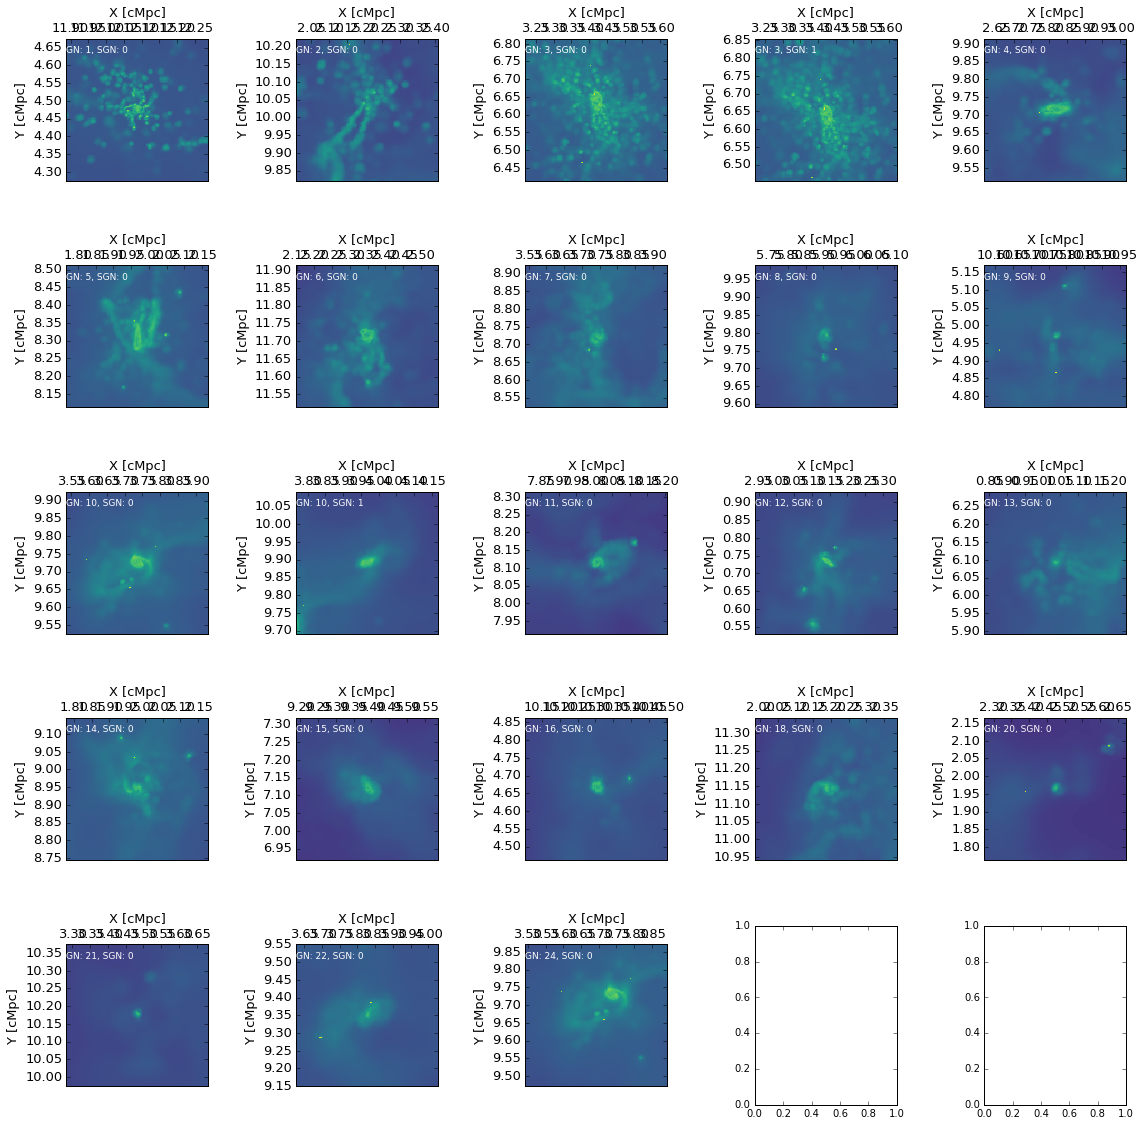

In [58]:
f, axarr = plt.subplots(5, 5,figsize=(16,16))
profiles_x = []
profiles_y = []
halflen = 0.2 # cMpc
pixshape = data.shape[0]
print pixshape
for j,x,y,z,mass,gnum,sgnum,vx,vy,vz in zip(range(25),xgal_9andup,ygal_9andup,zgal_9andup,mgal_9andup,gn_9andup,sgn_9andup,vxgal_9andup,vygal_9andup,vzgal_9andup):

    data_tiny = data[(x-halflen)/12.5*pixshape:(x+halflen)/12.5*pixshape,(y-halflen)/12.5*pixshape:(y+halflen)/12.5*pixshape]
    xystarts_tiny = [x-halflen,y-halflen]
    size_tiny = halflen * 2.
    
    pltimg(data_tiny,axarr[j/5,j%5],xystarts_tiny,[size_tiny,size_tiny],colorbar=False,\
           label = 'GN: %s, SGN: %s'%(gnum,sgnum))
    
    print 'GN: %s, SGN: %s, x: %s, y: %s, z: %s, vx: %s, vy: %s, vz: %s' %(gnum,sgnum,x,y,z,vx,vy,vz)
    
plt.tight_layout()